# Arginine-glutamic acid dipeptide repeats (RERE)

The Arginine-glutamic acid dipeptide repeats (RERE) RERE gene encodes a nuclear receptor coregulator that positively regulates retinoic acid signaling [Fregeau et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27087320/). A high percentage of RERE pathogenic variants affect a 21 amino acid (amino acids 1425–1445), histidine-rich region of the Atrophin-1 domain [Jordan et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29330883/). The authors noted that Of the 19 individuals with NEDBEH described here and by Fregeau et al. (2016), nine (47%) carry sequence variants that affect a histidine-rich region of the Atrophin-1 domain that spans 21 amino acids (1425– 1445). The amino acid sequence in this region is 100% conserved down to Xenopus and zebrafish, but the functional significance of this domain is currently unknown.

It has been reported that point mutations in theatrophin-1 domain lead to a higher frequency of structural defects inthe brain, eye, heart, and kidney and sensorineural hearing loss ascompared to individuals with loss-of-function variants [Jordan et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29330883/) and [Niehaus et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36053530/).

Here we will perform an analysis similar to that shownin Table 3 of [Jordan et al (2018)](https://pubmed.ncbi.nlm.nih.gov/29330883/).

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### RERE
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for RERE.

In [2]:
gene_symbol = 'RERE'
mane_tx_id = 'NM_012102.4'
mane_protein_id = 'NP_036234.3' # FYVE, RhoGEF and PH domain-containing protein 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

phenopacket_store_release = '0.1.21' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
rere_folder = "../../../phenopacket-store/notebooks/RERE/phenopackets"

#cohort, qc = load_phenopacket_folder(rere_folder, cohort_creator=cohort_creator)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 19/19 [00:08<00:00,  2.25individuals/s]
Loaded 19 individuals
Validated under permissive policy
No errors or warnings were found


In [32]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,19
Intellectual disability,HP:0001249,18
Autistic behavior,HP:0000729,14
Hypotonia,HP:0001252,9
Thin corpus callosum,HP:0033725,7
Reduced cerebral white matter volume,HP:0034295,6
Short stature,HP:0004322,6
Ventricular septal defect,HP:0001629,5
Strabismus,HP:0000486,5
Scoliosis,HP:0002650,4


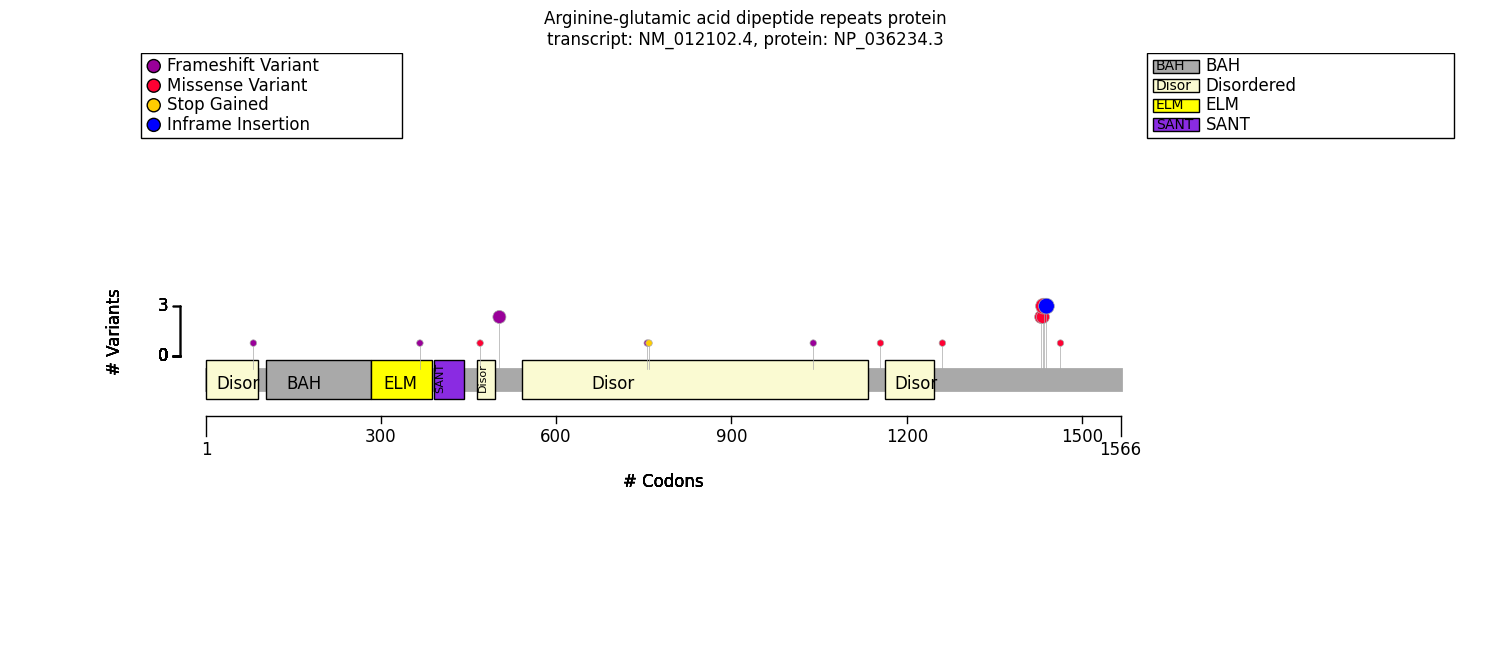

In [33]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [35]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 90,1,p.Ser84ValfsTer4
BAH,DOMAIN,103 - 283,0,
ELM2,DOMAIN,284 - 387,1,p.Leu369CysfsTer16
SANT,DOMAIN,391 - 443,0,
Disordered,REGION,464 - 495,1,p.Val471Ile
Disordered,REGION,542 - 1133,3,p.Pro1041LeufsTer40; p.Gln760Ter; p.Thr758SerfsTer36
Disordered,REGION,1162 - 1246,0,


In [36]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
1_8358216_8358216_T_TGGTGGA,c.4313_4318dup,p.Leu1438_His1439dup,21,inframe insertion,3
1_8364773_8364773_A_AC,c.1512dup,p.Tyr505ValfsTer37,15,frameshift,2
1_8358235_8358235_A_G,c.4300T>C,p.Ser1434Pro,21,missense,2
1_8358231_8358231_T_C,c.4304A>G,p.His1435Arg,21,missense,1
1_8358242_8358242_G_C,c.4293C>G,p.His1431Gln,21,missense,1
1_8361236_8361236_C_CCCTGGAGGAGCTGAGGAGGGAG,c.2249_2270dup,p.Thr758SerfsTer36,19,frameshift,1
1_8358232_8358232_G_A,c.4303C>T,p.His1435Tyr,21,missense,1
1_8359916_8359916_C_T,c.3466G>A,p.Gly1156Arg,20,missense,1
1_8365848_8365848_C_T,c.1411G>A,p.Val471Ile,14,missense,1
1_8495062_8495063_CT_C,c.1104del,p.Leu369CysfsTer16,11,"frameshift, splice region",1


# Genotype-Phenotype Correlation (GPC) Analysis

[Jordan VK, et al (2018) Genotype-phenotype correlations in individuals with pathogenic RERE variants. Hum Mutat](https://pubmed.ncbi.nlm.nih.gov/29330883/) 

> evaluated the incidence of structural defects of the brain, eye, heart, and kidney and sensorineural hearing loss between 
individiuals with missense variants in the atrophin domain and those with other variants (Table 3).

They identified a significant correlation with the count of defects in these organ systems. We perform a U test to compare the counts of malformations in these organ systems both netween atrophin domain variants vs. other and
between frameshift variants and others. 

[Jordan VK, et al (2018)](https://pubmed.ncbi.nlm.nih.gov/29330883/) speculated that 

> the more severe phenotype, seen in cases with pathogenic missense variants in the atophin-1 domain, may be due to a dominant negative mechanism with genera-tion of abnormal protein product.

We use the following HPO terms

- [Abnormal brain morphology (HP:0012443)](https://hpo.jax.org/browse/term/HP:0012443)
- [Abnormal eye morphology (HP:0012372)](https://hpo.jax.org/browse/term/HP:0012372)
- [Abnormal heart morphology (HP:0001627)](https://hpo.jax.org/browse/term/HP:0001627)
- [Abnormal renal morphology (HP:0012210)](https://hpo.jax.org/browse/term/HP:0012210)
- [Sensorineural hearing impairment (HP:0000407)](https://hpo.jax.org/browse/term/HP:0000407)

In [ ]:
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.model import VariantEffect

# loss of function variants
lof_effects = (
    VariantEffect.TRANSCRIPT_ABLATION,
    VariantEffect.FRAMESHIFT_VARIANT,
    VariantEffect.START_LOST,
    VariantEffect.STOP_GAINED,
)
lof_mutation = VariantPredicates.any(VariantPredicates.variant_effect(eff, mane_tx_id) for eff in lof_effects)
lof_predicate = monoallelic_predicate(
    a_predicate=lof_mutation,
    b_predicate=~lof_mutation,
    a_label="LoF",
    b_label="other")

In [38]:
from gpsea.model.genome import Region

atrophin_dom = VariantPredicates.region(Region(1425, 1445), mane_tx_id)
atrophin_pred = monoallelic_predicate(
    a_predicate=atrophin_dom,
    b_predicate=~atrophin_dom,
    a_label="Atrophin",
    b_label="other")

In [48]:
from gpsea.analysis.pscore import CountingPhenotypeScorer
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis

select_hpo = ("HP:0012443", "HP:0012372","HP:0001627","HP:0012210", "HP:0000407")

scorer = CountingPhenotypeScorer.from_query_curies(hpo, select_hpo)
score_stats = MannWhitneyStatistic()
score_analysis = PhenotypeScoreAnalysis(score_stats)

In [49]:
lof_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, lof_predicate, scorer)
print(f"p-value, loss of function variants: {lof_results.pval}")

p-value, loss of function variants: 0.0011911408611556503


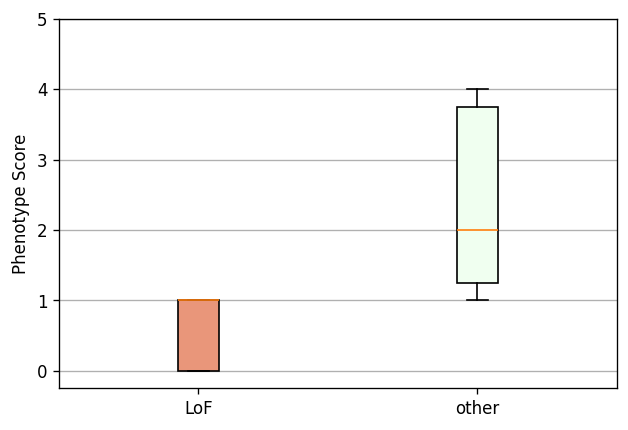

In [50]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize = (6,4), dpi = 120)
lof_results.plot_boxplots(ax=ax)
_= ax.grid(axis="y")
_= ax.set(ylabel="Phenotype Score", ylim=(-0.25, 5))

In [51]:
atrophin_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, atrophin_pred, scorer)
atrophin_results.pval
print(f"p-value, variants in atrophin domain: {atrophin_results.pval}")

p-value, variants in atrophin domain: 0.017590436496409435


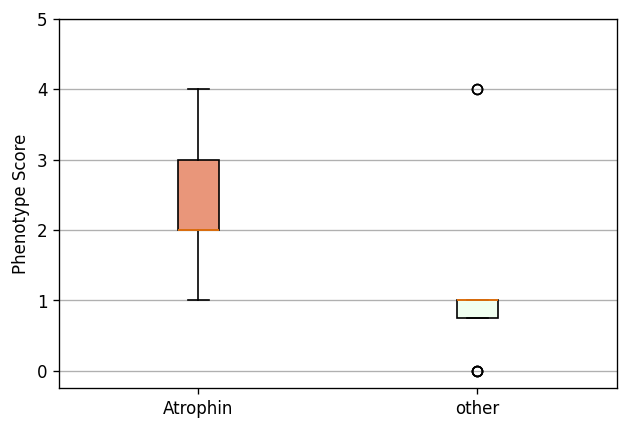

In [52]:
fig, ax = plt.subplots(figsize = (6,4), dpi = 120)
atrophin_results.plot_boxplots(ax)
_= ax.grid(axis="y")
_= ax.set(ylabel="Phenotype Score", ylim=(-0.25, 5))

In [53]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

is_frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
fet_frameshift_predicate = monoallelic_predicate(
    a_predicate=is_frameshift,
    b_predicate=~is_frameshift,
    a_label="frameshift",
    b_label="other"
)

In [54]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [55]:
fet_frameshift_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=fet_frameshift_predicate,
    pheno_predicates=pheno_predicates,
)

In [56]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=fet_frameshift_result)

Allele group                                       frameshift          other  \
                                                        Count Percent  Count   
Short stature [HP:0004322]                                0/5      0%    6/9   
Intellectual disability [HP:0001249]                      3/5     60%  15/15   
Thin corpus callosum [HP:0033725]                         0/2      0%    7/8   
Global developmental delay [HP:0001263]                   4/6     67%  15/15   
Reduced cerebral white matter volume [HP:0034295]         0/2      0%    6/7   
Poor suck [HP:0002033]                                    2/5     40%    0/7   
Ventriculomegaly [HP:0002119]                             0/4      0%    4/8   
Hypotonia [HP:0001252]                                    1/6     17%   8/16   
Autistic behavior [HP:0000729]                            4/5     80%  10/10   
Attention deficit hyperactivity disorder [HP:00...        2/5     40%    1/8   
Abnormal axial skeleton morphology [HP:0009121]           3/3    100%    7/7   
Abnormal ocular adnexa morphology [HP:0030669]            4/4    100%    6/6   
Morphological central nervous system abnormalit...        1/1    100%  10/10   
Diagnostic behavioral phenotype [HP:0025783]              4/4    100%  10/10   
Atypical behavior [HP:0000708]                            5/5    100%  11/11   
Neurodevelopmental delay [HP:0012758]                     4/4    100%  15/15   
Neurodevelopmental abnormality [HP:0012759]               4/4    100%  15/15   
Ventricular septal defect [HP:0001629]                    1/3     33%    4/8   
Abnormal cardiac septum morphology [HP:0001671]           2/2    100%    7/7   
Abnormal muscle tone [HP:0003808]                         2/2    100%    9/9   
Abnormal pinna morphology [HP:0000377]                    2/2    100%    7/7   

Allele group                                                                   \
                                                   Percent Corrected p values   
Short stature [HP:0004322]                             67%           0.350000   
Intellectual disability [HP:0001249]                  100%           0.350000   
Thin corpus callosum [HP:0033725]                      88%           0.350000   
Global developmental delay [HP:0001263]               100%           0.350000   
Reduced cerebral white matter volume [HP:0034295]      86%           0.350000   
Poor suck [HP:0002033]                                  0%           0.530303   
Ventriculomegaly [HP:0002119]                          50%           0.624242   
Hypotonia [HP:0001252]                                 50%           0.777778   
Autistic behavior [HP:0000729]                        100%           0.777778   
Attention deficit hyperactivity disorder [HP:00...     12%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]        100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Diagnostic behavioral phenotype [HP:0025783]          100%           1.000000   
Atypical behavior [HP:0000708]                        100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Ventricular septal defect [HP:0001629]                 50%           1.000000   
Abnormal cardiac septum morphology [HP:0001671]       100%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Abnormal pinna morphology [HP:0000377]                100%           1.000000   

Allele group                                                  
                                                    p values  
Short stature [HP:0004322]                          0.030969  
Intellectual disability [HP:0001249]                0.052632  
Thin corpus callosum [HP:0033725]          

In [57]:
from gpseacs.report import GpseaAnalysisReport

mono_results = [lof_results, atrophin_results]
fet_results = [fet_frameshift_result]
rere_caption = "TODO."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             mono_results=mono_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=rere_caption)

In [58]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

{'a_genotype': 'LoF', 'b_genotype': 'other', 'name': 'HPO Group Count', 'test_name': 'HPO Group Count', 'description': 'Assign a phenotype score that is equivalent to the count of present phenotypes that are either an exact match to the query terms or their descendants', 'variable_name': 'HPO group count', 'pval': '0.001'}
{'a_genotype': 'Atrophin', 'b_genotype': 'other', 'name': 'HPO Group Count', 'test_name': 'HPO Group Count', 'description': 'Assign a phenotype score that is equivalent to the count of present phenotypes that are either an exact match to the query terms or their descendants', 'variable_name': 'HPO group count', 'pval': '0.018'}
